Import necessary packages

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sqlite3

import statsmodels.api as sm
import statsmodels.stats.api as sms
from statsmodels.formula.api import ols
from statsmodels.stats.diagnostic import linear_rainbow
from statsmodels.stats.diagnostic import het_breuschpagan
from statsmodels.stats.outliers_influence import variance_inflation_factor

from custom_functions import *

pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)
%matplotlib inline
%load_ext autoreload
%autoreload 2

Import dataset that was cleaned and prepared in Data Preparation notebook

In [2]:
conn = sqlite3.connect('../../data/processed/main.db')
query = '''SELECT * FROM step2_encoded'''
df_main = pd.read_sql(query, conn, index_col='index').reset_index(drop=True)
conn.close()

df_main.head(3)
y = 'SalePrice'

In [3]:
# Split all data columns into 'categorical' and 'continuous'
x_cat_vs_cont = {'categorical': ['HeatSystem', 'HeatSource', 'forced_air_vs_other'], 
                 'discrete': ['BldgGrade', 'Condition', 'Stories', 'NbrLivingUnits', 'FinBasementGrade', 'Bedrooms', 'Bathrooms', 'Fireplaces'],
                 'continuous': ['SqFtTotLiving', 'SqFtTotBasement', 'SqFtGarageAttached','SqFtOpenPorch', 
                             'SqFtEnclosedPorch', 'SqFtDeck','BrickStone', 'YrBuilt', 'YrRenovated', 'SqFtUnfinished']}

In [4]:
# Run Step-wise selection algorithm to eliminate irrelevant features
X = df_main.drop(y, axis=1)
keepers = stepwise_selection(X, df_main[y], verbose=False)

# Determine which features were removed
removed = list(df_main.drop(y, axis=1).columns)
for item in keepers:
    removed.remove(item)

print('Remaining features:', keepers)
print('Removed features:', removed)

df_main = df_main[[y] + keepers].copy()

Remaining features: ['SqFtTotLiving', 'BldgGrade', 'YrBuilt', 'SqFtGarageAttached', 'Bedrooms', 'Bathrooms', 'SqFtOpenPorch', 'forced_air_vs_other', 'YrRenovated', 'HeatSource', 'HeatSystem', 'Condition', 'SqFtDeck']
Removed features: ['NbrLivingUnits', 'Stories', 'SqFtTotBasement', 'FinBasementGrade', 'SqFtEnclosedPorch', 'BrickStone', 'SqFtUnfinished', 'Fireplaces']


In [5]:
xs = df_main.drop(y, axis=1).columns
model, df_main = produce_model(df_main, xs, y, 3)

Modeling: SalePrice ~ SqFtTotLiving+BldgGrade+YrBuilt+SqFtGarageAttached+Bedrooms+Bathrooms+SqFtOpenPorch+forced_air_vs_other+YrRenovated+HeatSource+HeatSystem+Condition+SqFtDeck 



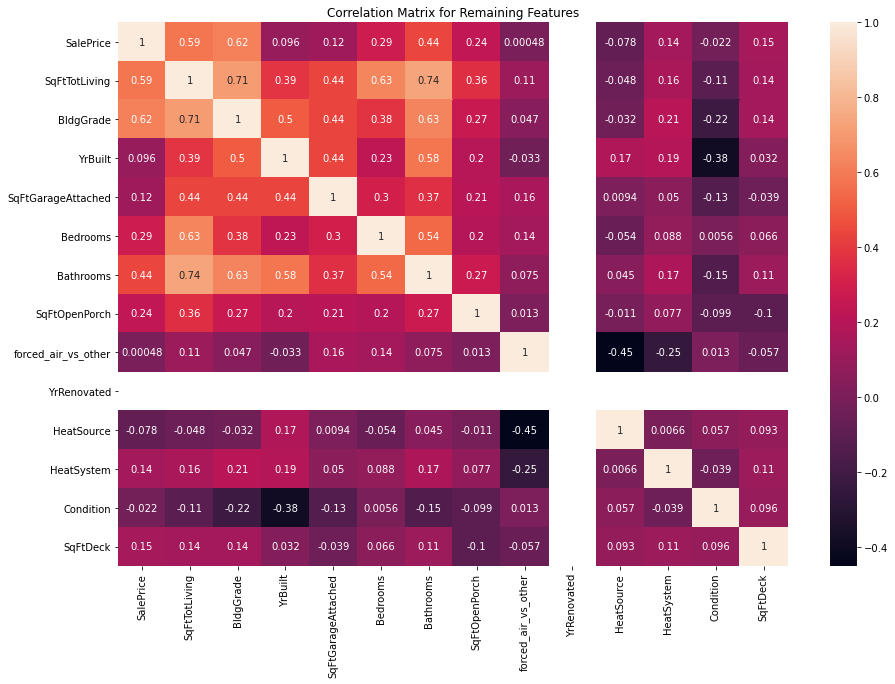

In [6]:
CorrMatrix = df_main.corr()
plt.figure(figsize=(15,10))
sns.heatmap(CorrMatrix, annot=True)
plt.title('Correlation Matrix for Remaining Features');

C:\Users\seths\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\misc.py:80: UserWarning: Attempting to set identical left == right == 0.0 results in singular transformations; automatically expanding.
  ax.set_xlim(boundaries_list[j])
C:\Users\seths\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\misc.py:81: UserWarning: Attempting to set identical bottom == top == 0.0 results in singular transformations; automatically expanding.
  ax.set_ylim(boundaries_list[i])
C:\Users\seths\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\misc.py:71: UserWarning: Attempting to set identical left == right == 0.0 results in singular transformations; automatically expanding.
  ax.set_xlim(boundaries_list[i])


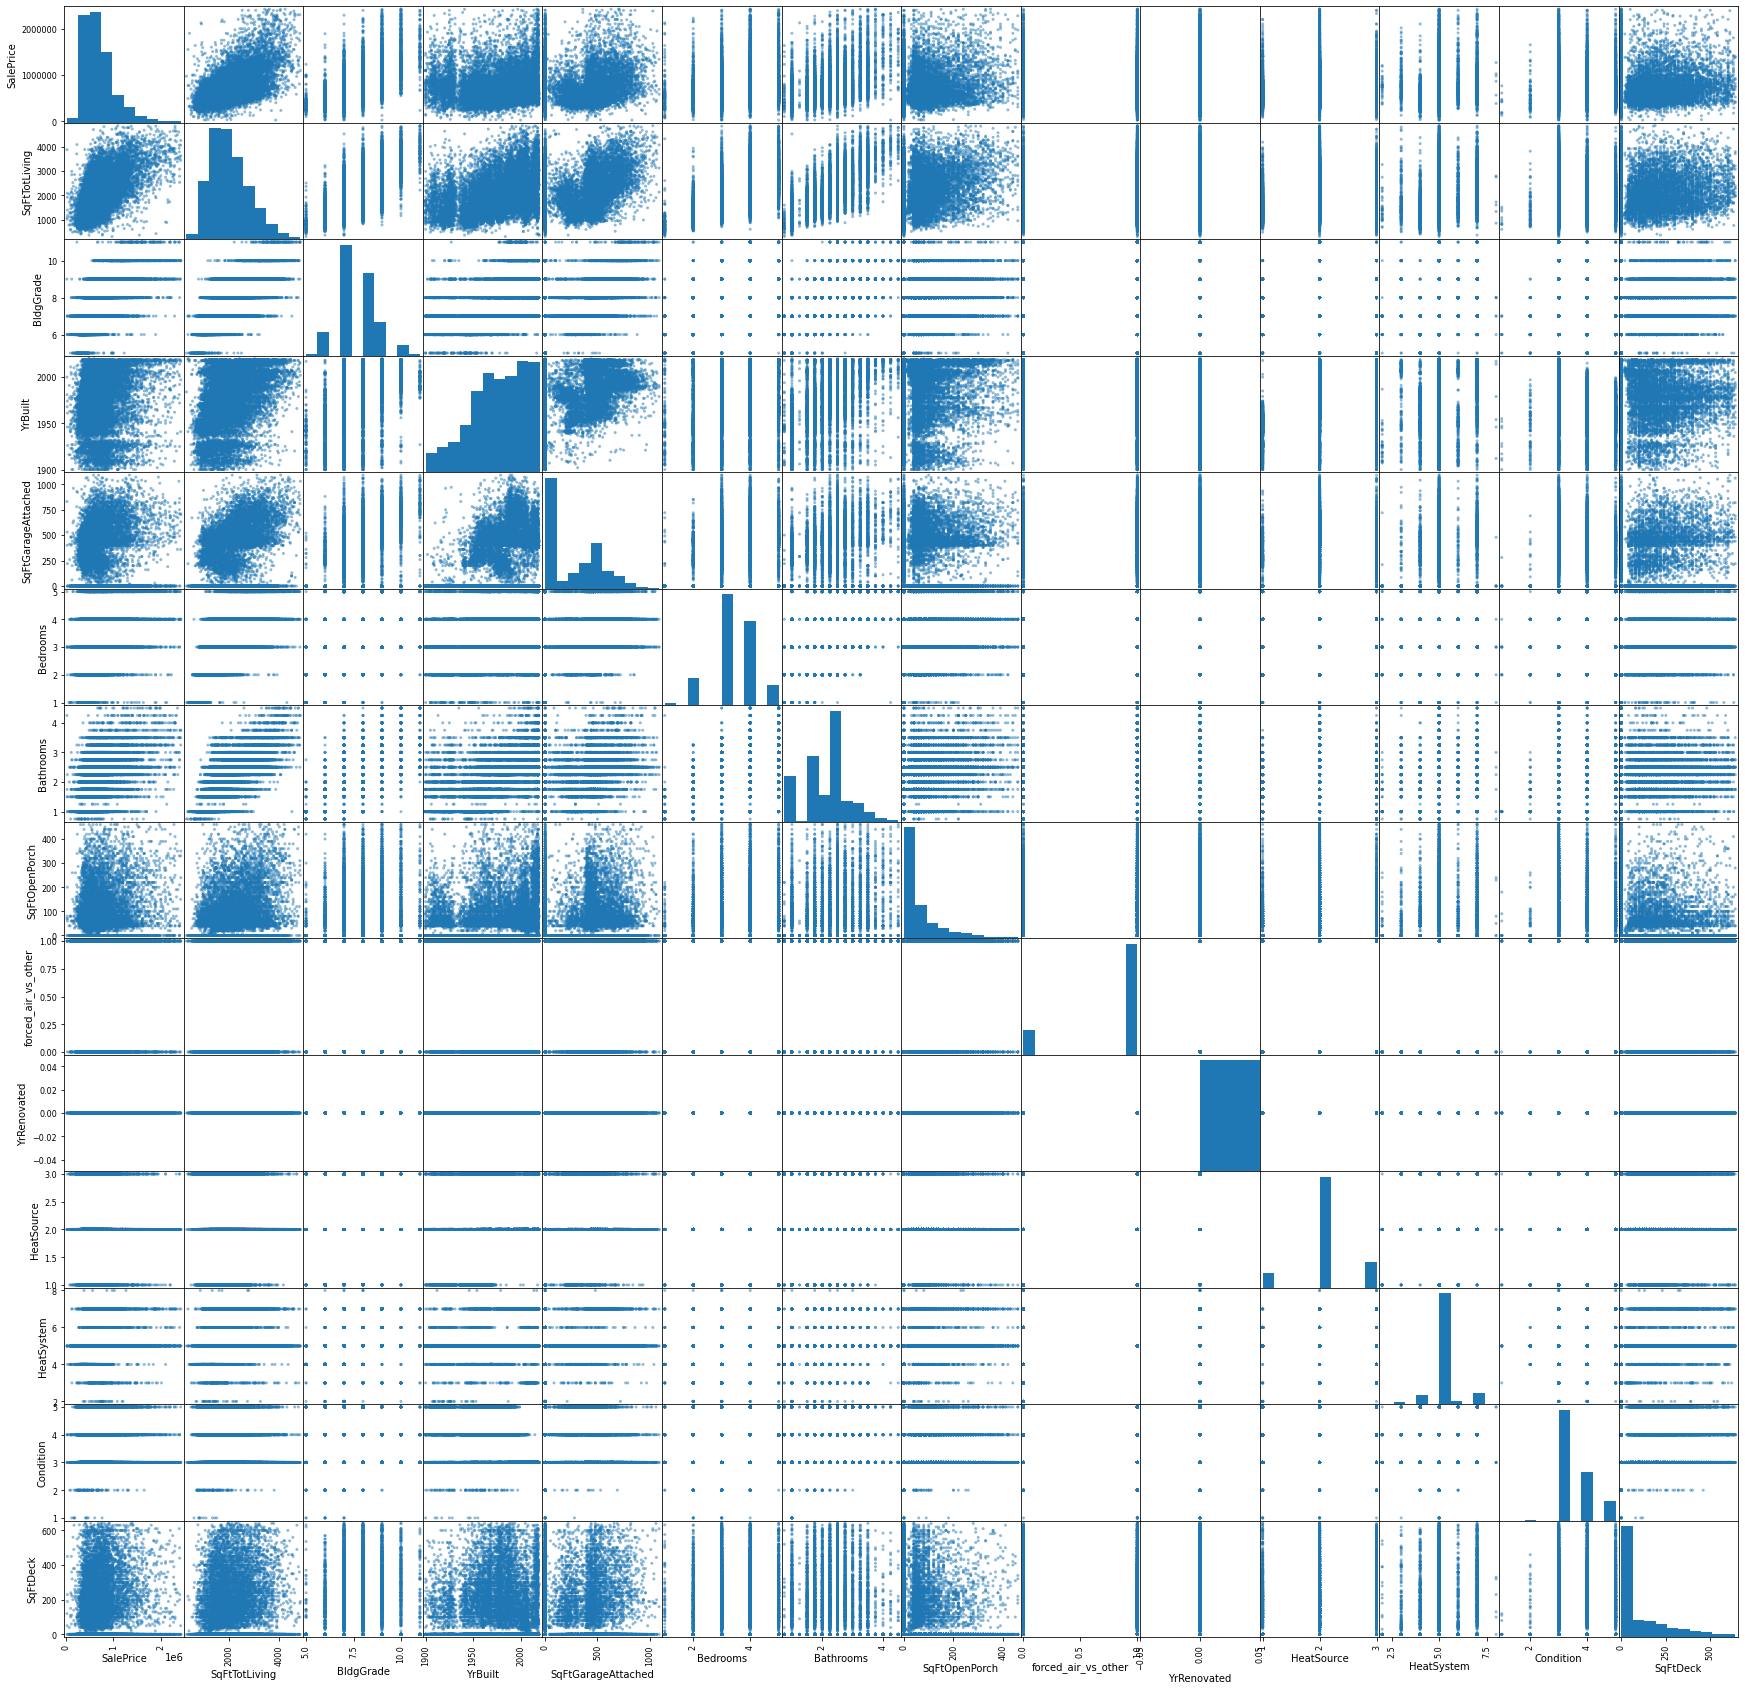

In [7]:
pd.plotting.scatter_matrix(df_main, figsize=(30,30));

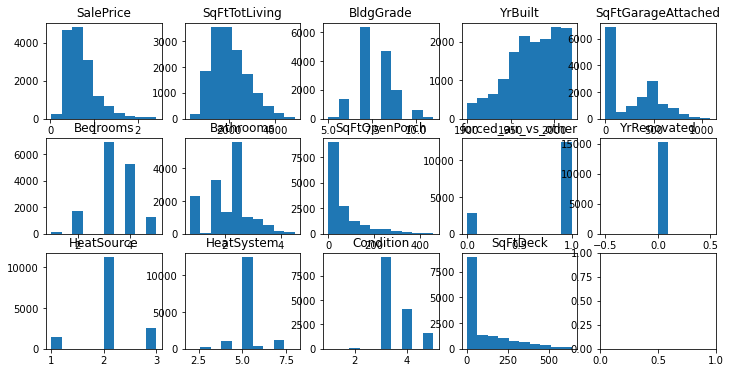

In [16]:
# Plot Histograms

fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(12,6))

for col, ax in zip(df_main.columns, axes.flatten()):
    ax.hist(df_main[col])
    ax.set_title(col)

In [19]:
correlations = df_main.corr().stack().reset_index()
correlations = correlations.loc[(correlations.level_0 == 'SalePrice') & (correlations.level_1 != 'SalePrice')]
correlations[0] = correlations[0].abs()
correlations.columns = ['Dependent', 'Feature', 'Correlation (abs)']

correlations.sort_values(by='Correlation (abs)', ascending=False, inplace=True)
correlations.reset_index(inplace=True, drop=True)

correlations

,Dependent,Feature,Correlation (abs)
0,SalePrice,BldgGrade,0.619727
1,SalePrice,SqFtTotLiving,0.586104
2,SalePrice,Bathrooms,0.442576
3,SalePrice,Bedrooms,0.286370
4,SalePrice,SqFtOpenPorch,0.236103
5,SalePrice,SqFtDeck,0.145828
6,SalePrice,HeatSystem,0.136113
7,SalePrice,SqFtGarageAttached,0.118583
8,SalePrice,YrBuilt,0.096138
9,SalePrice,HeatSource,0.078371


# Check Assumptions

In [20]:
def check_assumptions(model, df, feature_to_plot=False):
    linearity(model, df, supress_figures=True)
    normality(model, df)
    homoscedacity(model, df)
    independence(model, df, supress_figures=True)   

    
def linearity(model, df, supress_figures=False):
    lr = linear_rainbow(model)
    p = lr[1]
    print('Linearity p-value (where null hypothesis = linear):', p)
    
    if supress_figures == False:
        sns.pairplot(df)
        plt.suptitle('Investigating Linearity of Inputs', y=1.05)
    return p


def normality(model, df, plot_feature=False):
    jb = sms.jarque_bera(model.resid)
    print('Normality of Residuals (where null hypothesis = normality): JB stat={}, JB stat p-value={}'.format(jb[0], jb[1]))
    
    if plot_feature != False:
        sm.graphics.qqplot(df[plot_feature], line='45', fit=True)
        plt.title('Normality of Residuals:', col);
    return jb[0], jb[1]    


def homoscedacity(model, df, plot_feature=False):
    bp = het_breuschpagan(model.resid, model.model.exog)
    p_lm, p_f = bp[1], bp[3]
    print("Homoscedacity (where null hypothesis = homoscedastic): lagrange p-value={} and f-value's p-value={}".format(p_lm, p_f))
    
    if plot_feature != False:
        predicted = model.predict()
        error = df[y] - predicted
        plt.scatter(df[plot_feature], error, alpha=0.3, )
        plt.plot([df[plot_feature].min(), df[plot_feature].max()], [0,0], color='black')
        plt.xlabel(plot_feature)
        plt.ylabel("Error (Actual-Predicted)")
        plt.title('Homoscedacity of Residuals');
    return p_lm, p_f


# CITATION: function content taken from Flatiron School Study Group material
def independence(model, df, supress_figures=False):
    features = df.drop(y, axis=1).columns
    
    df_vif = pd.DataFrame()
    df_vif['Feature'] = features
    df_vif['VIF'] = [variance_inflation_factor(df.drop(y, axis=1).values, i) for i in range (len(features))]
    
    if supress_figures == False:
        CorrMatrix = df.corr()
        #plt.figure(figsize=(15,10))
        sns.heatmap(CorrMatrix, annot=True)
    print('\nVariance Inflation Factors:\n', df_vif)
    return df_vif

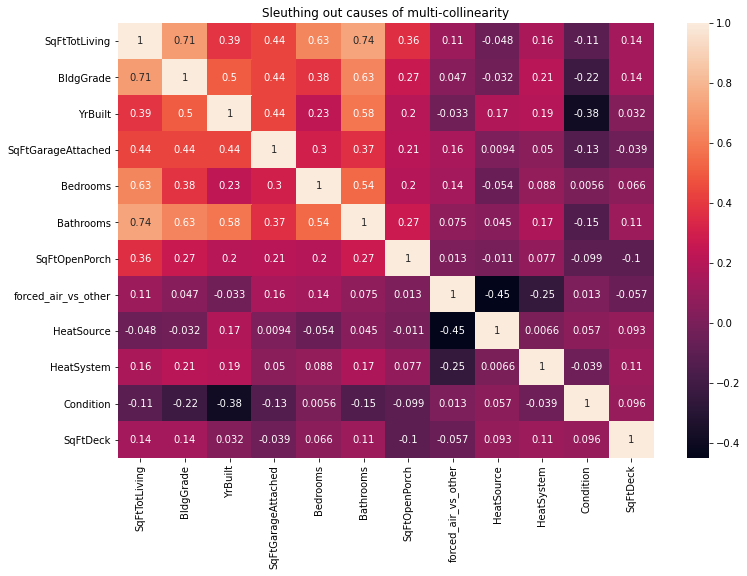

In [29]:
CorrMatrix = df_main.drop(['YrRenovated', 'SalePrice'], axis=1).corr()
plt.figure(figsize=(12,8))
sns.heatmap(CorrMatrix, annot=True)
plt.title('Sleuthing out causes of multi-collinearity');

# START HERE: TRY TO FIGURE OUT HOW WE CAN HAVE A LOW VIF

In [38]:
includes = ['YrBuilt', 'Bedrooms', 'SqFtOpenPorch']
vif = pd.DataFrame()
vif['VIF Factor'] =  [variance_inflation_factor(df_main[includes].values, i) for i in range(df_main[includes].shape[1])]
vif["features"] = df_main[includes].columns
vif

,VIF Factor,features
0,18.420172,YrBuilt
1,19.087627,Bedrooms
2,1.524891,SqFtOpenPorch


In [32]:
drops = ['YrRenovated', 'SalePrice']

vif = pd.DataFrame()
X_drops = df_main.drop(drops, axis=1)
vif["VIF Factor"] = [variance_inflation_factor(X_drops.values, i) for i in range(X_drops.shape[1])]
vif["features"] = X_drops.columns
vif

,VIF Factor,features
0,29.764339,SqFtTotLiving
1,136.359446,BldgGrade
2,242.625889,YrBuilt
3,2.618630,SqFtGarageAttached
4,32.044711,Bedrooms
5,24.836717,Bathrooms
6,1.744297,SqFtOpenPorch
7,7.782368,forced_air_vs_other
8,23.861559,HeatSource
9,64.465045,HeatSystem


In [ ]:
features = df_main.drop([y, 'NbrLivingUnits'], axis=1).columns#['SqFtTotLiving', 'YrBuilt']
model, df = produce_model(df_main, features, y, 3, drop_zeros=False)
check_assumptions(model, df)

In [ ]:


fig, axes = plt.subplots(2, 5, figsize=(25,10))

df_x_continuous = df_main[x_cat_vs_cont['continuous']].copy()
for col, ax in zip(df_x_continuous.columns, axes.flatten()):
    df = pd.concat([df_main[y], df_x_continuous[col]], axis=1)
    cleaned = remove_df_extremes(df, devct=3, drop_zeros=True)
    ax.scatter(y = y, x = col, data=cleaned)
    ax.set_title(col)
    

    
    